# Homework 4


## Part I
We set up the PyMC confirgurations and conduct posterior inferences based on the model <br>
<br>
$$\large
\overset{x_i\; \sim\; \text{location-scale-t}(\mu, \tau^2, \nu)}{\quad\quad\quad p(x|\mu,\tau^2, \nu)} = {\prod_{i=1}^n
\frac{\Gamma\left(\frac{\nu+1}{2}\right)}{\Gamma\left(\frac{\nu}{2}\right) \sqrt{\pi \nu \tau^2}}\left(1+\frac{1}{\nu} \frac{(x_i-\mu)^2}{\tau^2}\right)^{-(\nu+1) / 2}}$$


$$\scriptsize {p(\mu | \mu_0, \sigma_0^2) = \sqrt{\frac{1}{2\pi \sigma_0^2}} e^{-\frac{\left(\mu-\mu_0\right)^2}{2\sigma_0^2}}}\quad {p(\tau^2 | \sigma_1^2) = \frac{\sqrt{2}}{\sigma_1 \sqrt{\pi}} \exp \left(-\frac{(\tau^2)^2}{2 \sigma_1^2}\right)} \quad p(\nu=i) = \Bigg\{ \begin{array}{cl} \frac{1}{100} & \text{for }i=1,\cdots,100\\ 0 & \text{otherwise} \end{array}
$$

$$\tiny \text{normal} \quad\quad\quad\quad\quad\quad\quad \text{half-normal} \quad\quad\quad\quad\quad\quad\quad\quad \text{discrete uniform}$$


In [1]:
import numpy as np
import pymc as pm
from scipy import stats

# Set seed
np.random.seed(123)

# Initialize Prior Hyperparameters
mu_0,sigma_0=0,10 # Normal-Prior for mu (location parameter for the observe data)
sigma_1 =5 # Half Normal Prior for tau (scale parameter for the observe data)
L,U = 1, 101 # Discrete Uniform Prior for nu (df parameter for the observe data)

# Real Parameters
loc_true,scale_true,df_true = 10,2,15 # True values data will be from

# Generate Random Observations
N = 500 # Number of observations
x = stats.t(df=df_true, loc=loc_true, scale=scale_true).rvs(N) # Generate observations

# Initialize the student_T_mixture_model
student_T_mixture_model = pm.Model()
with student_T_mixture_model:
    mu = pm.Normal("mu", mu=mu_0, sigma=sigma_0)
    tau = pm.HalfNormal('tau', sigma=sigma_1)
    nu = pm.DiscreteUniform('nu', lower = L, upper = U)
    x_obs = pm.StudentT('likelihood', nu=nu, mu=mu, sigma=1/tau**0.5, observed=x)

In [2]:
# Conduct Hamiltonian Monte Carlo (HMC)
with student_T_mixture_model:
    idata_HMC = pm.sample(1000, chains=4, cores=4) # default is the NUTS implementation of HMC

/usr/local/lib/python3.10/dist-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),
/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


### Sanity Check of Convergence


/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


HMC Split-Rhats {'mu': 1.0015, 'nu': 1.0632, 'tau': 1.0358}


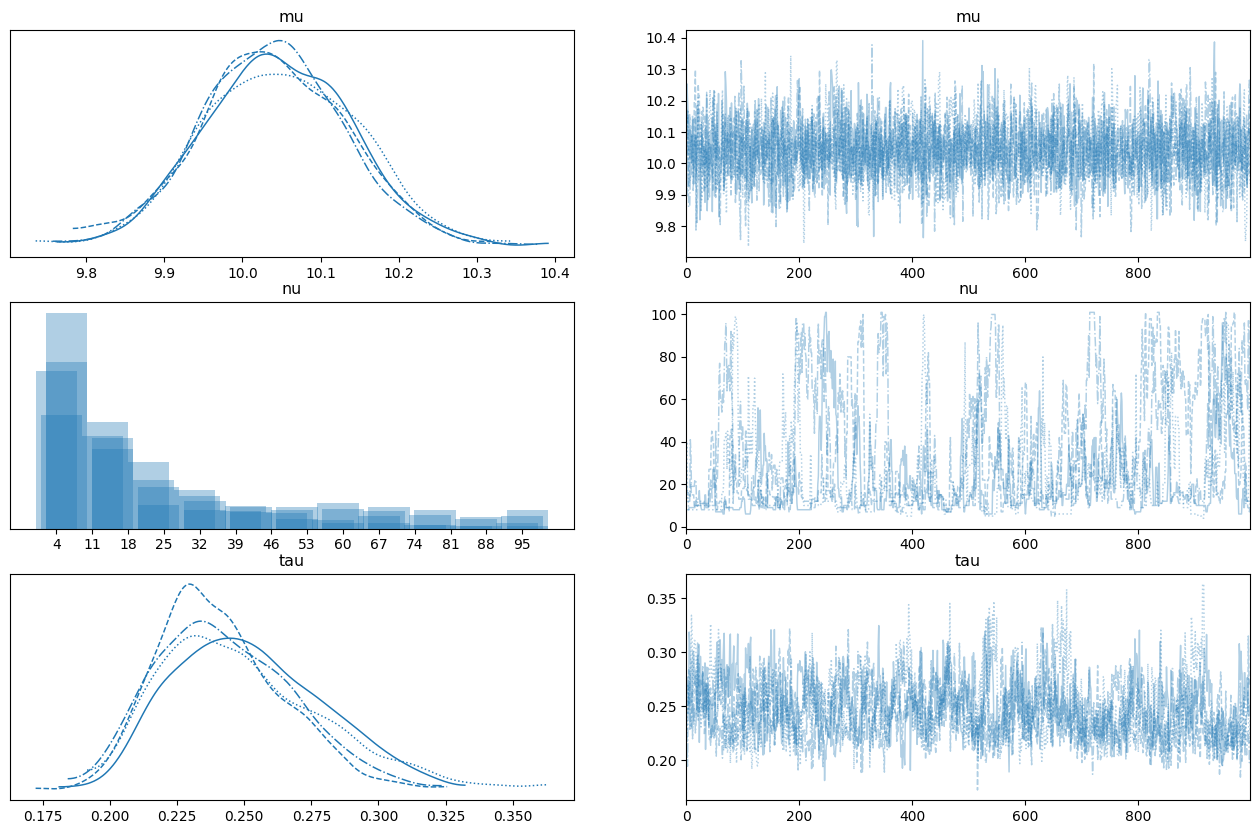

In [3]:
import arviz as az; import matplotlib.pyplot as plt;
fig,ax = plt.subplots(3,2, figsize=(16,10))
az.plot_trace(idata_HMC, axes=ax[:3,:3])
print("HMC Split-Rhats", {k: np.round(v.values,4) for k,v in az.rhat(idata_HMC).items()})

### Credible Intervals - HDI
We generate 95% HDI for the degree of freedom parameter $\nu$

In [4]:
# Output the 95% Highest Density Interval
interval = az.hdi(idata_HMC, hdi_prob=0.95)
print(interval)

<xarray.Dataset>
Dimensions:  (hdi: 2)
Coordinates:
  * hdi      (hdi) <U6 'lower' 'higher'
Data variables:
    mu       (hdi) float64 9.853 10.22
    nu       (hdi) float64 5.0 82.0
    tau      (hdi) float64 0.2001 0.3018


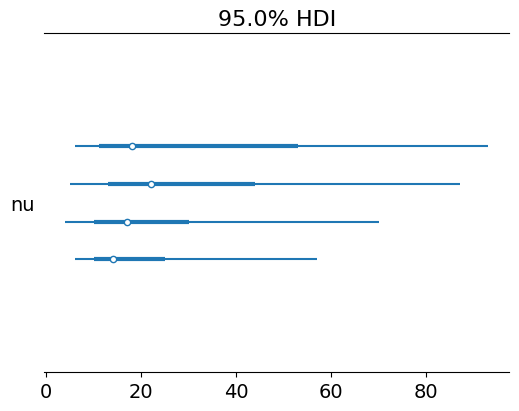

In [5]:
import arviz as az; import matplotlib.pyplot as plt; #fig,ax = plt.subplots(1,1, figsize=(14,6))
az.plot_forest(idata_HMC, var_names=["nu"], combined=False, hdi_prob=0.95);

## MCMC Chain Analysis
We conduct MCMC Chain analysis by ploting the MC chain, analysing its auto-correlation and effective sample size


## MC Chain plots

Text(0.5, 1.0, 'HMC - Empirical Distribution for the df parameter')

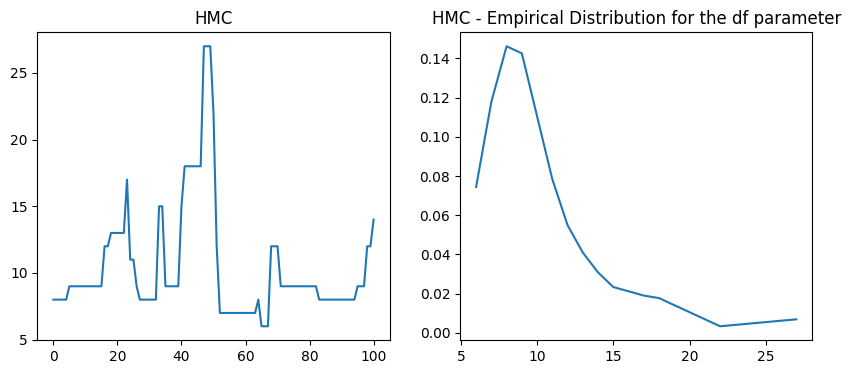

In [6]:
from scipy.stats import gaussian_kde; import matplotlib.pyplot as plt;
n_mcmc_samples = 100
fig,ax = plt.subplots(1,2, figsize=(10,4))
mcmc_chain = idata_HMC.posterior["nu"].sel(chain=0, draw=slice(0, n_mcmc_samples)).values
mcmc_chain_sorted = sorted(mcmc_chain)
ax[0].plot(mcmc_chain);
ax[1].plot(mcmc_chain_sorted,gaussian_kde(mcmc_chain_sorted)(mcmc_chain_sorted));
ax[0].set_title("HMC");
ax[1].set_title("HMC - Empirical Distribution for the df parameter")

## Auto-Correlation Plot
We compute and plot the auto-correlation for the MCMC chain below. We can see that the autocorrelation of $(\nu_i)$ for our particular MCMC chain approximately 0.88. This number is significantly larger than 0. So, it suggests that the terms in our MCMC chain is extremly stickly with each other. As a results, it seems like we need a much longer time and larger samples (i.e. small effecitve sample size) for the chain to converge to the stable distribution.

Autocorrelation for HMC (MCMC) chain 0.9296221571547607


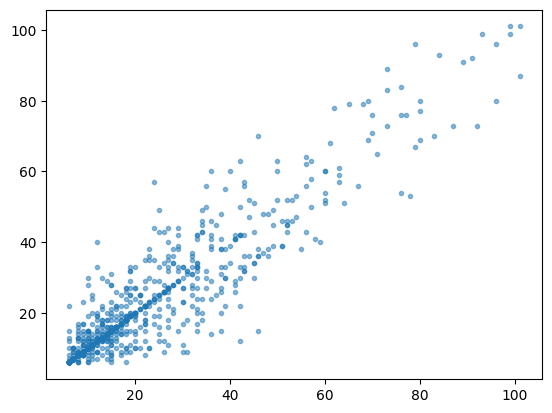

In [7]:
import matplotlib.pyplot as plt;
fig,ax = plt.subplots(1,1)
max_mcmc_samples = 1000
mcmc_chain = idata_HMC.posterior["nu"].sel(chain=0, draw=slice(0, max_mcmc_samples-2)).values;
mcmc_chain_one_step_ahead = idata_HMC.posterior["nu"].sel(chain=0, draw=slice(1, max_mcmc_samples-1)).values;
ax.plot(mcmc_chain, mcmc_chain_one_step_ahead, '.', alpha=0.5)
print("Autocorrelation for HMC (MCMC) chain", np.corrcoef(mcmc_chain,mcmc_chain_one_step_ahead)[0,1])

## Effective Sample Size
We compute the effecitve sample size in this step. This is an alternative metric to assess the efficiency of our HMC approach.<br>
According to the computation, given a 4000 samples, the effective sample size is around 142. Which is significantly lower than the actual sample size. This observation is as expected since we have a very large autocorrelation of the MCMC chain.

In [8]:
import arviz as az; print("number of MCMC samples:", idata_HMC.posterior['nu'].values.flatten().shape[-1])
az.summary(idata_HMC, round_to=4)

number of MCMC samples: 4000


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,10.0430,0.0946,9.8714,10.2220,0.0018,0.0013,2632.1513,2585.1685,1.0015
nu,27.3625,23.4456,5.0000,78.0000,3.0507,2.1679,64.8283,259.8154,1.0632
tau,0.2462,0.0272,0.2000,0.2967,0.0022,0.0016,152.1602,605.7306,1.0358


## Round II - Increasing the sample size to 8000 for $\nu$ posterior inferences
We try to answer the question, whether a bigger sample will mitigate our issues found in the analysis above.

In [9]:
with student_T_mixture_model:
    edata_HMC = pm.sample(4000, chains=4, cores=4) # default is the NUTS implementation of HMC

/usr/local/lib/python3.10/dist-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


/usr/local/lib/python3.10/dist-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


## HDI, Autocorrelation and Effective Sample Analysis

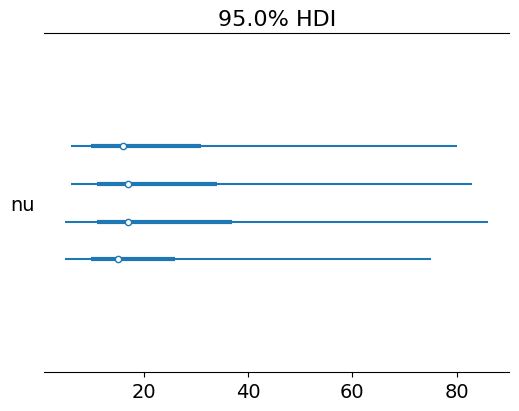

In [10]:
import arviz as az; import matplotlib.pyplot as plt; #fig,ax = plt.subplots(1,1, figsize=(14,6))
az.plot_forest(edata_HMC, var_names=["nu"], combined=False, hdi_prob=0.95);

Autocorrelation for HMC (MCMC) chain 0.9362120112175781


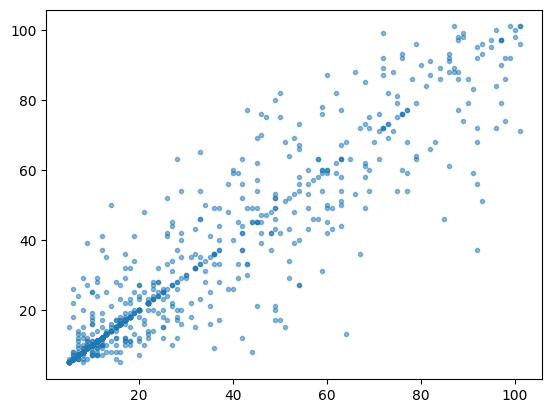

In [11]:
import matplotlib.pyplot as plt;
fig,ax = plt.subplots(1,1)
max_mcmc_samples = 1000
mcmc_chain = edata_HMC.posterior["nu"].sel(chain=0, draw=slice(0, max_mcmc_samples-2)).values;
mcmc_chain_one_step_ahead = edata_HMC.posterior["nu"].sel(chain=0, draw=slice(1, max_mcmc_samples-1)).values;
ax.plot(mcmc_chain, mcmc_chain_one_step_ahead, '.', alpha=0.5)
print("Autocorrelation for HMC (MCMC) chain", np.corrcoef(mcmc_chain,mcmc_chain_one_step_ahead)[0,1])

In [12]:
import arviz as az; print("number of MCMC samples:", edata_HMC.posterior['nu'].values.flatten().shape[-1])
az.summary(edata_HMC, round_to=4)

number of MCMC samples: 16000


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,10.0387,0.0965,9.8552,10.2164,0.0009,0.0006,11414.4992,8676.3187,1.0003
nu,25.7919,22.9267,5.0000,78.0000,1.0258,0.7258,526.3964,1071.7040,1.0081
tau,0.2479,0.0275,0.2008,0.3001,0.0009,0.0006,896.7827,3299.1048,1.0045


## Foundings
A larger sample size does not improve our situation. According to our simulation result, the autocorrelations of our simulated $(\nu_i)$ increases to approximately 0.92. It becomes sticker. The high correlation among the sample $\nu_i$ makes all simulated samples (espeacially on the tail) stick together and converges to the true degree of freedom ($\nu$) in a extremely slow manner. In fact, with this high auto-correlation, they might never converge to the true $\nu$ under practical computational constraints.<br>
However, like what we are found in the lecutre slids, the sever autocorrelation structure is due to the construction of Metropolis-Hastings Algorithms and can not be avoid

# Part II: HMC Diagnositcs


## (i) Posterior analysis
We conduct Metropolis - Hastings PyMC of the configuration in Part I with 8000 simulated trails and report the following diagnostics metrics


In [13]:
# Conduct Hamiltonian Monte Carlo (HMC)
with student_T_mixture_model:
    sdata_HMC = pm.sample(2000, chains=4, cores=4) # default is the NUTS implementation of HMC

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


### a. Effective Sample size

In [14]:
import arviz as az; print("number of MCMC samples:", sdata_HMC.posterior['nu'].values.flatten().shape[-1])
az.summary(sdata_HMC, round_to=4)

number of MCMC samples: 8000


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,10.0383,0.0960,9.8615,10.2210,0.0012,0.0008,6876.8848,5430.0599,1.0006
nu,25.7936,22.2322,5.0000,74.0000,1.2415,0.8787,362.1882,567.6793,1.0106
tau,0.2473,0.0274,0.2008,0.2995,0.0011,0.0008,580.6814,1701.6955,1.0054


### b. Chain convergence measures

HMC Split-Rhats {'mu': 1.0006, 'nu': 1.0106, 'tau': 1.0054}


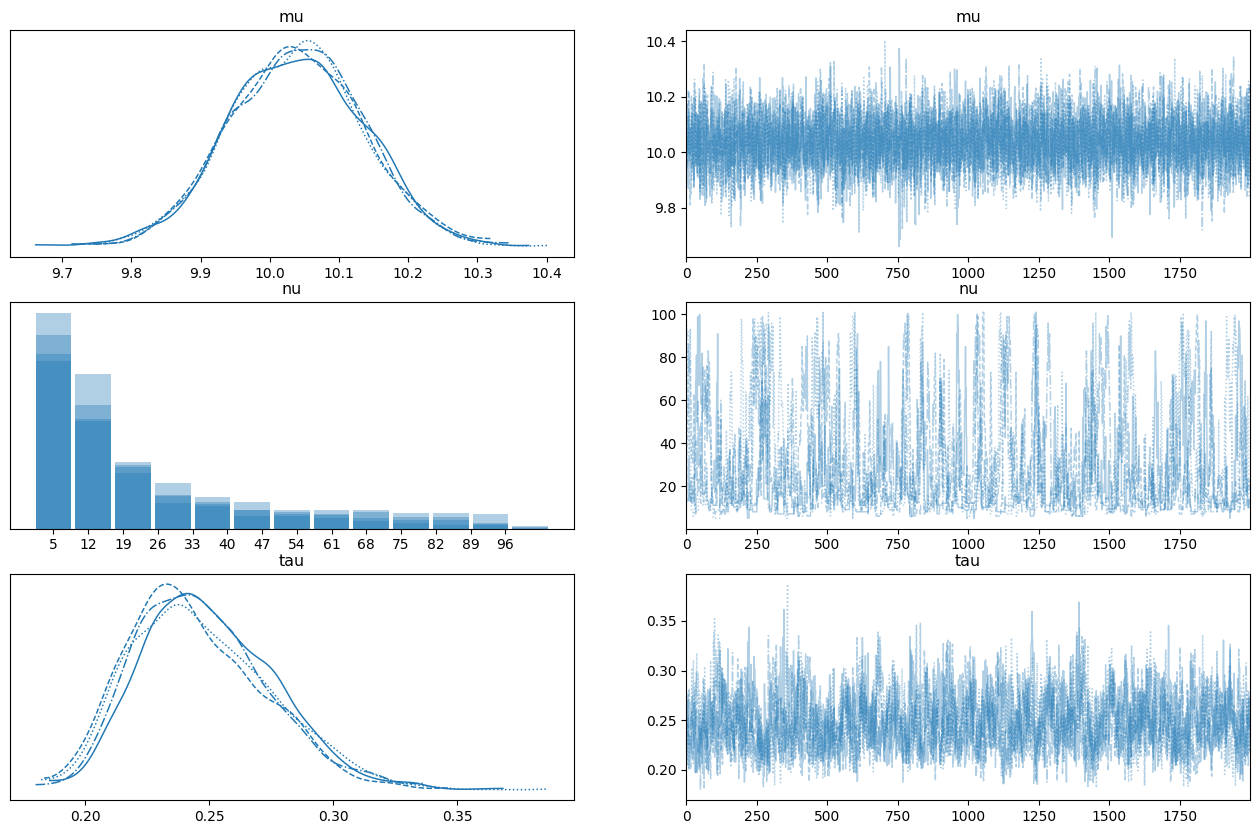

In [15]:
import arviz as az; import matplotlib.pyplot as plt;
fig,ax = plt.subplots(3,2, figsize=(16,10))
az.plot_trace(sdata_HMC, axes=ax[:3,:3])
print("HMC Split-Rhats", {k: np.round(v.values,4) for k,v in az.rhat(sdata_HMC).items()})

### c. Divergence
According to the simulation output, there is 0 divergence for the simulated trails

### d. Metropolis-Hastings acceptance rates


In [16]:
sdata_HMC.sample_stats.acceptance_rate.values.flatten()

array([0.47459237, 1.        , 0.93822488, ..., 0.79665218, 0.67975982,
       0.28856827])

### e. Warnings
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation.

## (ii) Run the same posterior analysis for Eight Schools for the "centered"

In [17]:
import numpy as np
import pymc as pm

J = 8
y = np.array([28.0, 8.0, -3.0, 7.0, -1.0, 1.0, 18.0, 12.0])
sigma = np.array([15.0, 10.0, 16.0, 11.0, 9.0, 11.0, 10.0, 18.0])

# Set up the model
with pm.Model() as Centered_eight:

    # We assume the following prior distributions for our parameters
    mu = pm.Normal("mu", mu=0, sigma=5)
    tau = pm.HalfCauchy("tau", beta=5)

    # and we assume the following probabilistic hierarchy
    # within the data generating mechanism
    theta = pm.Normal("theta", mu=mu, sigma=tau, shape=J) # theta is length J=8

    # Note that if tau was small, then the density evalution above
    # could change rapidly for changes in theta
    # This means that the energy has high curvature

    # likelihood where observed information enters into the model
    obs = pm.Normal("obs", mu=theta, sigma=sigma, observed=y)

# Conduct PyMC simulation
SEED = [20100420, 20134234] # random seeds for each of two run HMC chains
with Centered_eight:
    fit_C = pm.sample(5000, chains=2, tune=1000, random_seed=SEED,
                      return_inferencedata=True, idata_kwargs={"log_likelihood": True})

### a. Effective Sample size

In [18]:
import arviz as az; print("number of MCMC samples:", fit_C.posterior['mu'].values.flatten().shape[-1])
az.summary(fit_C, round_to=4)

number of MCMC samples: 10000


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,4.2983,3.3916,-1.9781,10.5547,0.1366,0.0966,622.7734,372.1421,1.0055
theta[0],6.6046,6.2537,-3.9705,19.0703,0.2220,0.1570,538.4590,1066.2164,1.0065
theta[1],5.0138,5.0651,-4.2772,14.8709,0.1464,0.1036,978.3639,2058.6191,1.0039
theta[2],3.6791,5.6584,-7.1052,14.1714,0.1237,0.0874,1575.0520,3789.1599,1.0032
theta[3],4.7593,5.1316,-5.0403,14.3579,0.1528,0.1081,964.7367,3571.4682,1.0046
theta[4],3.3596,5.0669,-6.5904,12.7075,0.1186,0.0872,1673.4907,2949.0121,1.0017
theta[5],3.8541,5.1246,-5.8393,13.5776,0.1110,0.0837,1769.3517,3374.0802,1.0035
theta[6],6.7127,5.4658,-2.6452,17.4757,0.2451,0.1734,415.2280,977.8747,1.0060
theta[7],4.8574,5.7027,-5.7360,16.0074,0.1324,0.0936,1248.4238,3856.9497,1.0024
tau,4.2964,3.3071,0.8375,10.2246,0.1708,0.1209,128.6585,95.3369,1.0226


### b. Chain Covergence measures

HMC Split-Rhats {'mu': 1.0055, 'theta': array([1.0065, 1.0039, 1.0032, 1.0046, 1.0017, 1.0035, 1.006 , 1.0024]), 'tau': 1.0226}


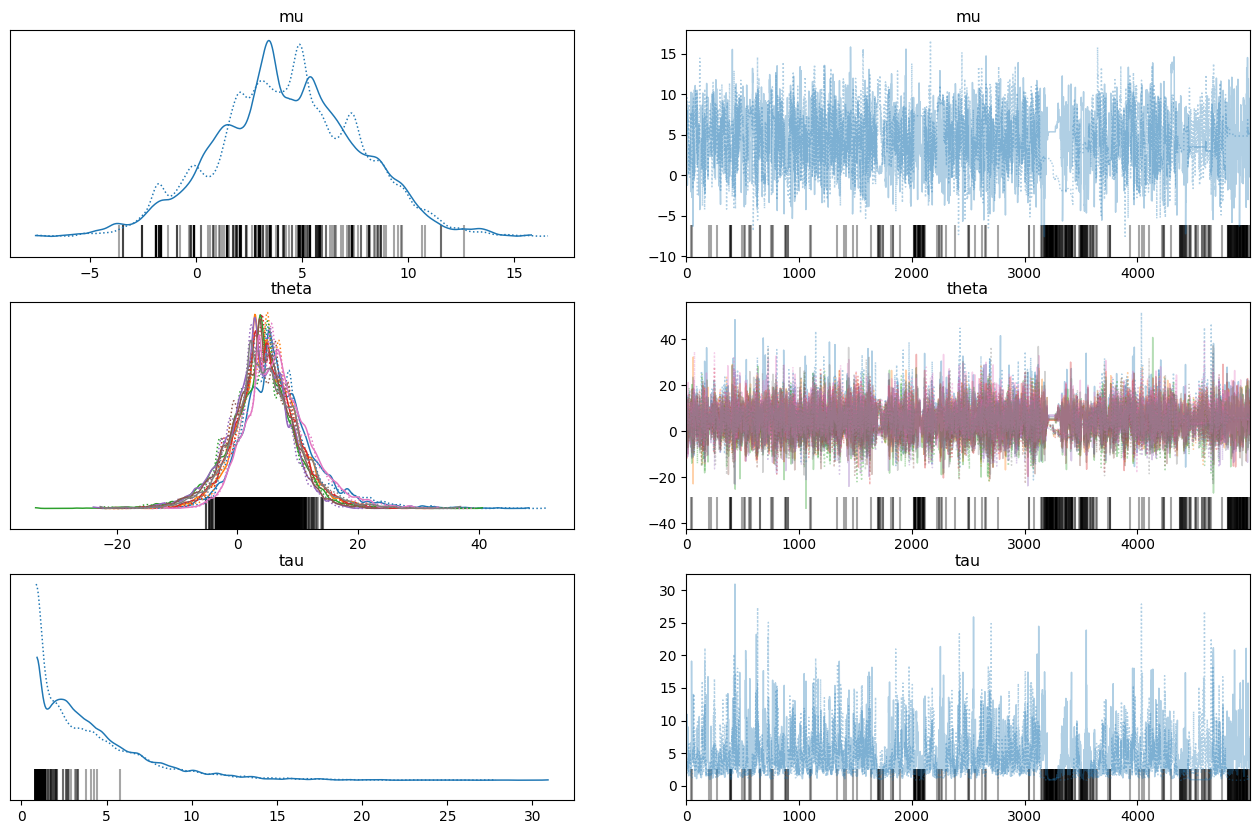

In [19]:
import arviz as az; import matplotlib.pyplot as plt;
fig,ax = plt.subplots(3,2, figsize=(16,10))
az.plot_trace(fit_C, axes=ax[:3,:3])
print("HMC Split-Rhats", {k: np.round(v.values,4) for k,v in az.rhat(fit_C).items()})

### c. divergence
There are 71 divergence in Samping chain 0 and 283 divergence in Sampling chain 1. This implies that we've been drifted out from the mass of our target distribution. Our density evaluation is extremely samll so that the acceptance probability of push the simulation dynamic forward is almost 0

### d. Metropolis-Hastings Acceptance rates
We have almost 0 accpetance probabiltiy, which is consist with our inference above based on the observation of divergence trails.

In [20]:
print(fit_C.sample_stats.acceptance_rate.values.flatten())

[7.57529151e-01 9.72231513e-01 9.54940855e-01 ... 5.70538494e-04
 6.60861775e-02 3.10133553e-06]


### e. No particular warnings except for the divergence output of PyMC

## (iii) Run the same posterior analysis for Eight Schools for the "centered"

In [21]:
# As is seen above, there are many divergences because the specification above
# induces high curature in the energy, but the following alternative
# parameterization alleviates this problem.

with pm.Model() as NonCentered_eight:

    mu = pm.Normal("mu", mu=0, sigma=5)
    tau = pm.HalfCauchy("tau", beta=5)
    theta_tilde = pm.Normal("theta_t", mu=0, sigma=1, shape=J)
    # Changes in theta now take place on a fixed scale that is independent of tau

    theta = pm.Deterministic("theta", mu + tau * theta_tilde)
    # Changes in tau can still result in rapid changes in the density evaluations
    # below so the energy still has high curvature with respect to tau; but,
    # it no longer has high curvature with respect to theta
    obs = pm.Normal("obs", mu=theta, sigma=sigma, observed=y)

with NonCentered_eight:
    fit_NC = pm.sample(5000, chains=2, tune=1000, random_seed=SEED,
                       return_inferencedata=True, idata_kwargs={"log_likelihood": True})

In [22]:
# Output the effective sample size

import arviz as az; print("number of MCMC samples:", fit_NC.posterior['mu'].values.flatten().shape[-1])
az.summary(fit_NC, round_to=4)

number of MCMC samples: 10000


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,4.4049,3.2990,-1.7144,10.6872,0.0313,0.0239,11120.1233,6319.8180,1.0001
theta_t[0],0.3251,1.0022,-1.5244,2.2513,0.0090,0.0104,12332.6012,6677.6507,1.0001
theta_t[1],0.1092,0.9306,-1.6554,1.8276,0.0081,0.0099,13263.2099,7097.1354,1.0002
theta_t[2],-0.0786,0.9756,-1.9708,1.7035,0.0079,0.0110,15199.4555,6188.7336,1.0000
theta_t[3],0.0659,0.9346,-1.7161,1.8344,0.0077,0.0103,14951.3007,7291.8996,0.9999
theta_t[4],-0.1536,0.9228,-1.8682,1.6224,0.0076,0.0099,14707.6886,7426.5037,1.0002
theta_t[5],-0.0797,0.9376,-1.7768,1.7512,0.0081,0.0102,13359.9412,7108.8672,1.0000
theta_t[6],0.3539,0.9549,-1.4341,2.1483,0.0089,0.0092,11562.5252,7108.0864,1.0001
theta_t[7],0.0706,0.9907,-1.7818,1.9109,0.0079,0.0119,15762.8327,6727.5984,1.0016
tau,3.5766,3.2024,0.0007,9.1843,0.0417,0.0345,5121.3955,3807.8676,1.0001


HMC Split-Rhats {'mu': 1.0001, 'theta_t': array([1.0001, 1.0002, 1.    , 0.9999, 1.0002, 1.    , 1.0001, 1.0016]), 'tau': 1.0001, 'theta': array([1.0002, 1.0002, 1.    , 1.0006, 1.0007, 0.9999, 0.9999, 1.    ])}


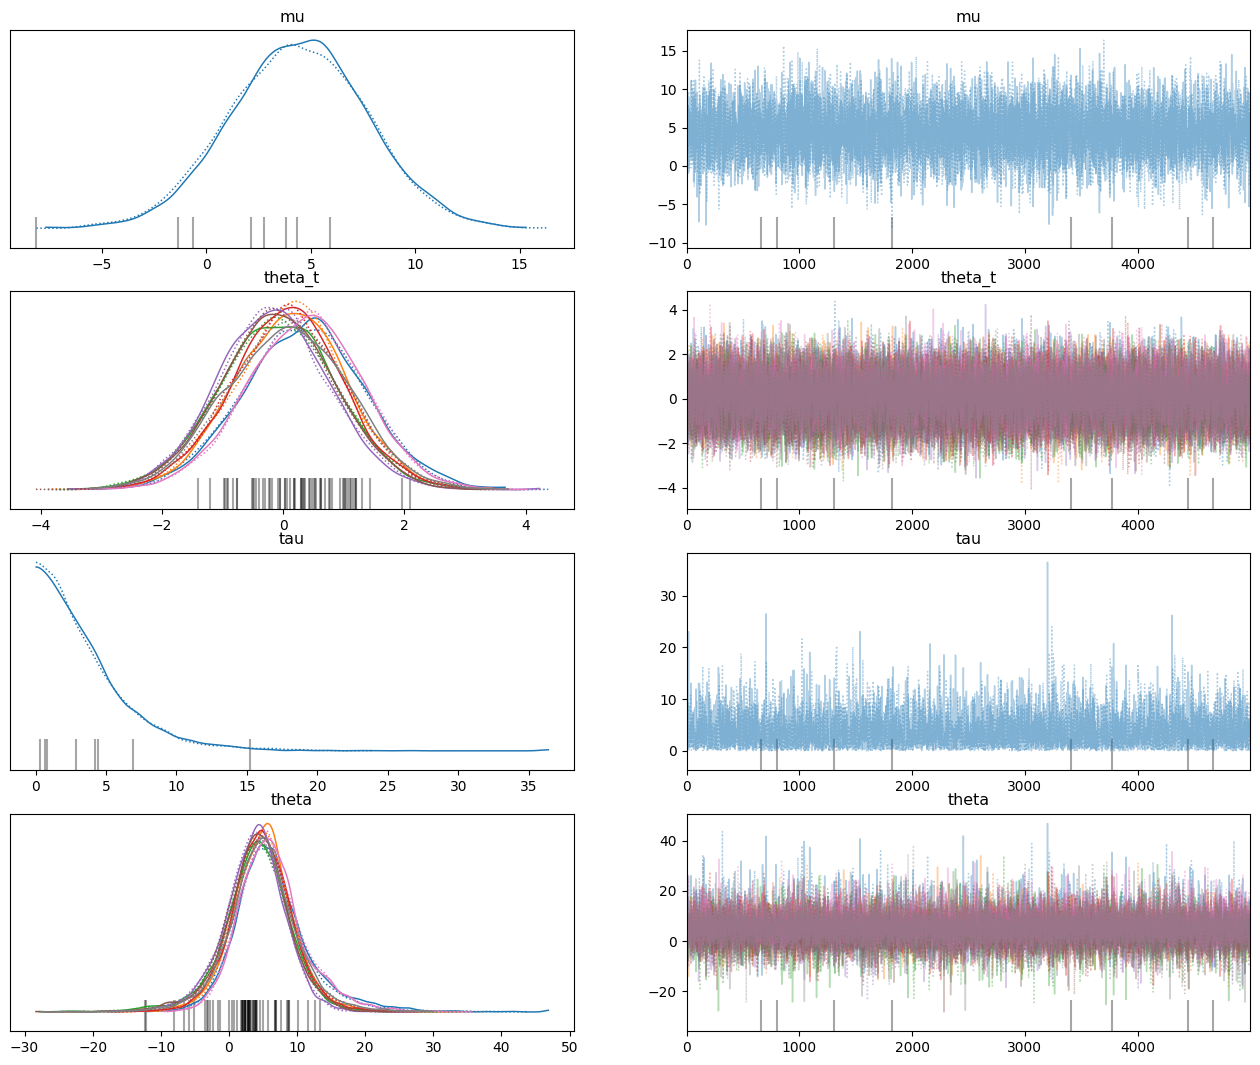

In [23]:
# Chain Convergence Measure
import arviz as az; import matplotlib.pyplot as plt;
fig,ax = plt.subplots(4,2, figsize=(16,13))
az.plot_trace(fit_NC, axes=ax[:4,:4])
print("HMC Split-Rhats", {k: np.round(v.values,4) for k,v in az.rhat(fit_NC).items()})

### c. divergence
There are only 5 divergence in Samping chain 0 and 3 divergence in Sampling chain 1.

In [24]:
# Acceptance Proabibilty
print(fit_NC.sample_stats.acceptance_rate.values.flatten())

[0.88841609 0.76184205 0.911938   ... 0.90839179 1.         0.60394672]


## (iii) Analysis on the comparions of centered and non-centered Eight School PyMC performance

For Centered Eight School simulation, HMC perform quite poorly since we have a lot of divergence and this suggests that potential energy (i.e. the parameters that we are instrested in) has a high curvature. Such high curvature cause us to "fell-off" the cliff of the support of our target distribution.<br>

To mitigate this issue, we reparametrized one of the parameter $\theta$ in the case of "Non-centered" simulation. The high curvature from the "Centered" case is caused by hierachy structure between $\tau$ and $\theta$. So, we decouple $\tau$ and $\theta$ by making $\theta$ as a fixed scale that is indepdent of $\tau$. This reduce the curvature siginifcantly and HMC perform much better in this case

## (iv) Energy Plot Analysis

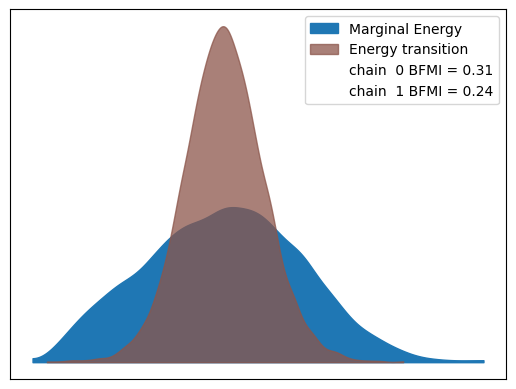

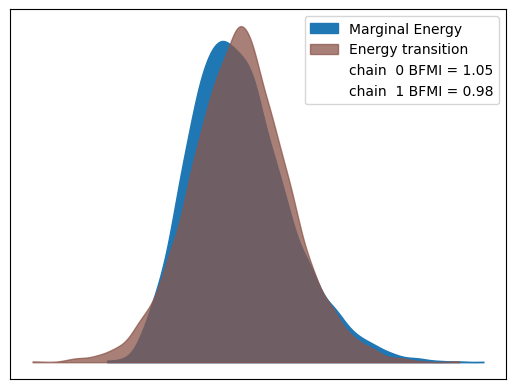

In [25]:
import arviz as az
az.plot_energy(fit_C);
az.plot_energy(fit_NC);

From the energy plot above, we can see that the Marginal Energy plot and Energy transition plot are very closed to each other for "Non centered" simulation. Conversely, the shape of the two plots are significantly different for the "centered" simulation. This shows that we have a less biased posterior distribution under the "Non centred" simulation than the "centered" one. Therefore, this diagnostic supports my previous conclusions. HMC perform much better in the "Non centered" type of simulation